In [3]:
from pyspark.sql import SparkSession
spark_session = SparkSession.builder\
    .appName("assignment_pyspark")\
    .master("local[2]")\
    .getOrCreate()

    
spark_context_new = spark_session.sparkContext
spark_context_new  

your 131072x1 screen size is bogus. expect trouble
24/08/26 21:22:14 WARN Utils: Your hostname, LAPTOP-7T85V9UE resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/26 21:22:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/26 21:22:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[2] appName=assignment_pyspark>

In [4]:
df_cal = spark_session.read.csv('/home/zano/project/assignment_pyspark/data/calendar.csv', header=True, inferSchema=True)
df_act = spark_session.read.csv('/home/zano/project/assignment_pyspark/data/customer_flight_activity.csv', header=True, inferSchema=True)
df_hist = spark_session.read.csv('/home/zano/project/assignment_pyspark/data/customer_loyalty_history.csv', header=True,inferSchema=True)


### DATA CLEANUP AND TRANSFORMATION

In [5]:
#join dataset df_act and df_hist
df_join = df_act.join(df_hist, df_act.loyalty_number == df_hist.loyalty_number, 'inner')

In [8]:
# Rename or Drop Duplicate Columns
# In this case, let's drop the duplicate column (if any)
df_join = df_join.drop(df_hist.loyalty_number)

In [9]:
#drop c0 column from df_cust 
df_join = df_join.drop('_c0')
df_join.printSchema()

root
 |-- loyalty_number: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- total_flights: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- points_accumulated: double (nullable = true)
 |-- points_redeemed: integer (nullable = true)
 |-- dollar_cost_points_redeemed: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- education: string (nullable = true)
 |-- salary: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- loyalty_card: string (nullable = true)
 |-- customer_lifetime_value: string (nullable = true)
 |-- enrollment_type: string (nullable = true)
 |-- enrollment_year: string (nullable = true)
 |-- enrollment_month: string (nullable = true)
 |-- cancellation_year: double (nullable = true)
 |-- cancellation

In [10]:
from pyspark.sql import functions as F

# Group by loyalty_number and aggregate the relevant metrics
df_summary = df_join.groupBy('loyalty_number').agg(
    F.sum('total_flights').alias('total_flights'),
    F.sum('distance').alias('total_distance'),
    F.sum('points_accumulated').alias('total_points_accumulated'),
    F.sum('points_redeemed').alias('total_points_redeemed'),
    F.sum('dollar_cost_points_redeemed').alias('total_dollar_cost_points_redeemed'),
    F.first('country').alias('country'),
    F.first('province').alias('province'),
    F.first('city').alias('city'),
    F.first('postal_code').alias('postal_code'),
    F.first('gender').alias('gender'),
    F.first('education').alias('education'),
    F.first('salary').alias('salary'),
    F.first('marital_status').alias('marital_status'),
    F.first('loyalty_card').alias('loyalty_card'),
    F.first('customer_lifetime_value').alias('customer_lifetime_value'),
    F.first('enrollment_type').alias('enrollment_type'),
    F.first('enrollment_year').alias('enrollment_year'),
    F.first('enrollment_month').alias('enrollment_month'),
    F.first('cancellation_year').alias('cancellation_year'),
    F.first('cancellation_month').alias('cancellation_month')
)

In [11]:
from pyspark.sql.functions import col, sum, when

# Count the null values in all columns
null_counts = df_summary.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_summary.columns])

null_counts.show()

24/08/26 21:27:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+-------------+--------------+------------------------+---------------------+---------------------------------+-------+--------+----+-----------+------+---------+------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|loyalty_number|total_flights|total_distance|total_points_accumulated|total_points_redeemed|total_dollar_cost_points_redeemed|country|province|city|postal_code|gender|education|salary|marital_status|loyalty_card|customer_lifetime_value|enrollment_type|enrollment_year|enrollment_month|cancellation_year|cancellation_month|
+--------------+-------------+--------------+------------------------+---------------------+---------------------------------+-------+--------+----+-----------+------+---------+------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|             0|            0| 

In [12]:
from pyspark.sql.functions import col, mean, when, count, isnan
# Handle null values Fill nulls with specific values
mean_salary = df_summary.select(mean(col("salary"))).collect()[0][0]
df_cleaned = df_summary.na.fill({
    "salary": mean_salary,
    "gender": "Unknown",
    "education": "Not Provided",
    "cancellation_year": 0.0,
    "cancellation_month": 0.0
})

In [13]:
from pyspark.sql.functions import col, sum, when

# Count the null values in all columns
null_counts = df_cleaned.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_cleaned.columns])

null_counts.show()
# check the number of rows
row_count = df_cleaned.count()

print(f"Number of rows: {row_count}")

+--------------+-------------+--------------+------------------------+---------------------+---------------------------------+-------+--------+----+-----------+------+---------+------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|loyalty_number|total_flights|total_distance|total_points_accumulated|total_points_redeemed|total_dollar_cost_points_redeemed|country|province|city|postal_code|gender|education|salary|marital_status|loyalty_card|customer_lifetime_value|enrollment_type|enrollment_year|enrollment_month|cancellation_year|cancellation_month|
+--------------+-------------+--------------+------------------------+---------------------+---------------------------------+-------+--------+----+-----------+------+---------+------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|             0|            0| 

In [14]:
#drop column that all null
#drop c0 column from df_cust 
df_cleaned = df_cleaned.drop('customer_lifetime_value', 'enrollment_year', 'enrollment_month')




In [15]:
# Perform additional transformations if necessary
df_transformed = df_cleaned.withColumn(
    "salary_bracket",
    when(col("salary") < 50000, "Low")
    .when((col("salary") >= 50000) & (col("salary") < 100000), "Medium")
    .otherwise("High")
)


In [17]:
# Save the transformed DataFrame to CSV
df_transformed.write.csv("exported_csv/transformed_customer_data.csv", header=True)

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/zano/project/assignment_pyspark/exported_csv/transformed_customer_data.csv already exists. Set mode as "overwrite" to overwrite the existing path.

### DATAVIZ

+--------------+-----+
|salary_bracket|count|
+--------------+-----+
|          High| 1521|
|           Low|  926|
|        Medium|14290|
+--------------+-----+



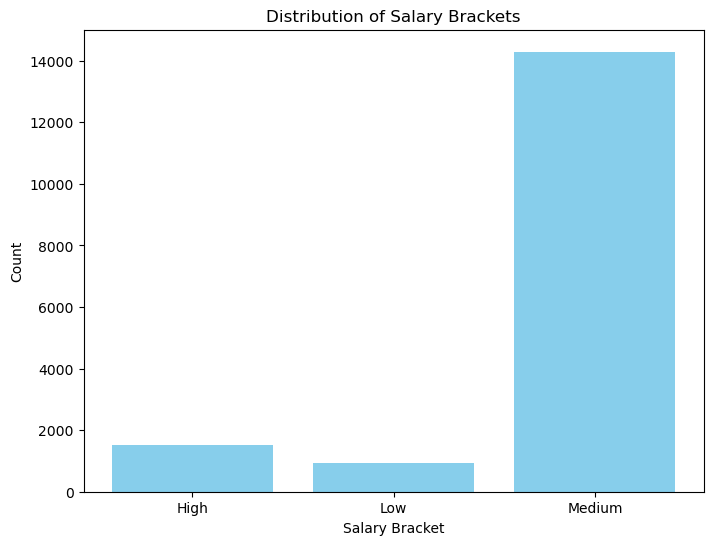

Plot saved to /home/zano/project/assignment_pyspark/exported_graphic/salary_brackets.png


/tmp/ipykernel_10647/4269002123.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="gender", y="avg_points", data=df_gender_points_pandas, palette="viridis")


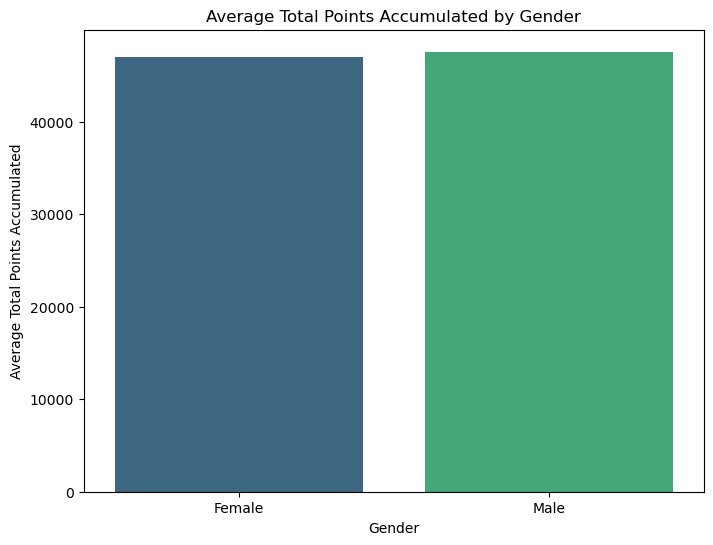

Plot saved to /home/zano/project/assignment_pyspark/exported_graphic/gender_distribution.png
+--------------------+------------------+
|            province| avg_total_flights|
+--------------------+------------------+
|            Manitoba|29.141337386018236|
|               Yukon|33.627272727272725|
|         Nova Scotia| 29.94980694980695|
|             Alberta|30.410732714138287|
|        Newfoundland|29.593023255813954|
|       New Brunswick| 31.38364779874214|
|        Saskatchewan|30.019559902200488|
|Prince Edward Island| 27.62121212121212|
|             Ontario|30.367320503330866|
|    British Columbia|30.659559990927647|
|              Quebec|30.294848484848483|
+--------------------+------------------+



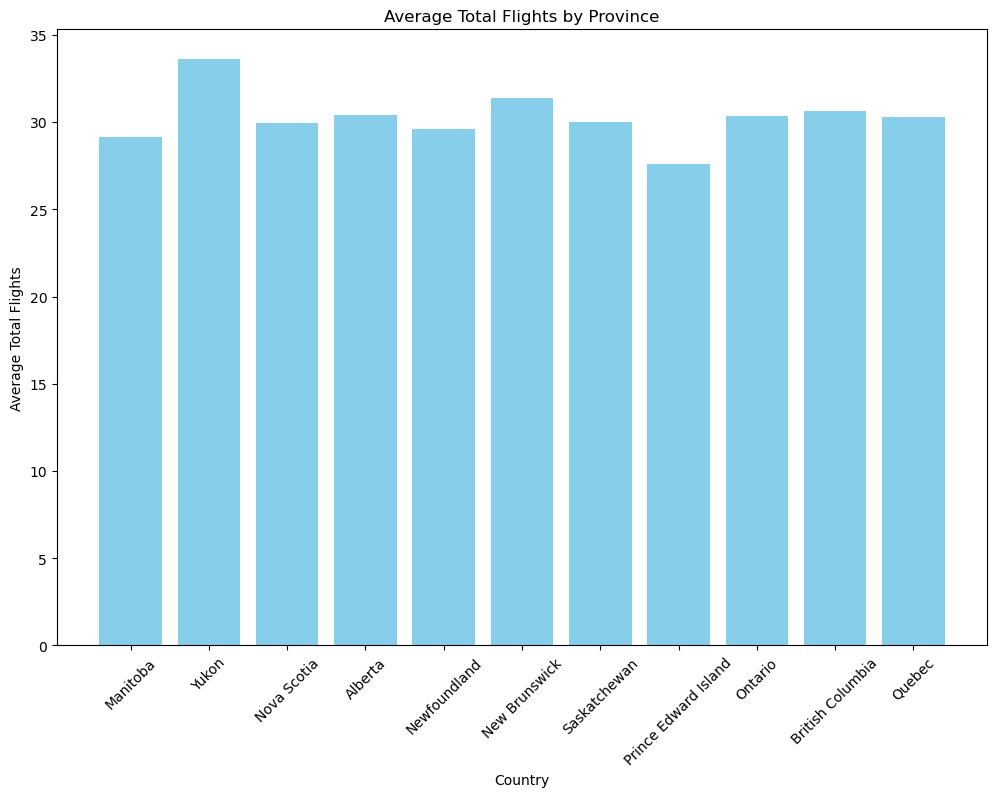

Plot saved to /home/zano/project/assignment_pyspark/exported_graphic/average_total_flights.png


In [20]:
import matplotlib.pyplot as plt
import os

# Register DataFrame as a SQL temporary view
df_transformed.createOrReplaceTempView("customer_data")

# Distribution of Salary Brackets
df_salary_brackets = spark_session.sql("""
SELECT salary_bracket, COUNT(*) as count
FROM customer_data
GROUP BY salary_bracket
""")
df_salary_brackets.show()

# Convert to Pandas for plotting
pd_salary_brackets = df_salary_brackets.toPandas()

# Plotting Salary Bracket Distribution
plt.figure(figsize=(8, 6))
plt.bar(pd_salary_brackets['salary_bracket'], pd_salary_brackets['count'], color='skyblue')
plt.title('Distribution of Salary Brackets')
plt.xlabel('Salary Bracket')
plt.ylabel('Count')

# Ensure the output directory exists
output_directory = '/home/zano/project/assignment_pyspark/exported_graphic/'
os.makedirs(output_directory, exist_ok=True)

# Save the plot as a PNG file before showing it
output_path = os.path.join(output_directory, 'salary_brackets.png')
plt.savefig(output_path)

# Now, display the plot
plt.show()

# Close the plot to free up memory
plt.close()

print(f"Plot saved to {output_path}")

# Gender Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data by gender and calculate the average total points accumulated
df_gender_points = df_transformed.groupBy("gender").agg(F.mean("total_points_accumulated").alias("avg_points"))

# Convert the result to a Pandas DataFrame for visualization
df_gender_points_pandas = df_gender_points.toPandas()

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(x="gender", y="avg_points", data=df_gender_points_pandas, palette="viridis")
plt.title("Average Total Points Accumulated by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Total Points Accumulated")

# Ensure the output directory exists
output_directory = '/home/zano/project/assignment_pyspark/exported_graphic/'
os.makedirs(output_directory, exist_ok=True)

# Save the plot as a PNG file before showing it
output_path = os.path.join(output_directory, 'gender_distribution.png')
plt.savefig(output_path)

# Now, display the plot
plt.show()

# Close the plot to free up memory
plt.close()

print(f"Plot saved to {output_path}")




# Average Total Flightsby Province
from pyspark.sql import functions as F

# Group by country and calculate the average total_flights
df_country_flights = df_transformed.groupBy("province").agg(F.mean("total_flights").alias("avg_total_flights"))

# Show the resulting DataFrame
df_country_flights.show()

# Convert to Pandas DataFrame
df_country_flights_pandas = df_country_flights.toPandas()

import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 8))
plt.bar(df_country_flights_pandas["province"], df_country_flights_pandas["avg_total_flights"], color='skyblue')
plt.title("Average Total Flights by Province")
plt.xlabel("Country")
plt.ylabel("Average Total Flights")
plt.xticks(rotation=45)

# Ensure the output directory exists
output_directory = '/home/zano/project/assignment_pyspark/exported_graphic/'
os.makedirs(output_directory, exist_ok=True)

# Save the plot as a PNG file before showing it
output_path = os.path.join(output_directory, 'average_total_flights.png')
plt.savefig(output_path)

# Now, display the plot
plt.show()

# Close the plot to free up memory
plt.close()

print(f"Plot saved to {output_path}")


